In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
plt.style.use('Solarize_Light2')


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import statsmodels.api as sm
import statsmodels.tsa.seasonal as seasonal
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import kpss

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from evaluation import forecast_accuracy

In [2]:
df = pd.read_pickle('../dataset/preprocessed/group_imputed.pkl')

In [3]:
df.head()

HotelId,DOA,DBA,ROH_max,ROH_min,ROH_med,ROH_avg,ROH_std,DOW,LAR_max,LAR_min,LAR_med,LAR_avg,LAR_std
0,2018-01-01,0.0,194.0,1.0,19.5,45.710526,65.541332,0,144.5,38.69,72.9,75.847778,30.871318
1,2018-01-01,1.0,194.0,1.0,25.0,47.368421,64.749892,0,144.5,38.69,72.9,75.847778,30.871318
2,2018-01-01,10.0,203.0,2.0,21.0,47.842105,67.742751,0,144.5,38.69,72.9,75.847778,30.871318
3,2018-01-01,11.0,203.0,3.0,22.0,48.368421,67.552872,0,144.5,38.69,72.9,75.847778,30.871318
4,2018-01-01,12.0,217.0,3.0,22.0,49.842105,70.976099,0,144.5,38.69,72.9,75.847778,30.871318


In [4]:
def preprocess(dx):
    dx = dx[dx['DBA']==0]
    dx = dx.rename(columns={'ROH_med':'ROH'})
    dx = dx[['DOA','ROH']]
    dx = dx.set_index('DOA')
    dx = dx.asfreq(freq='d', method='ffill')
    # scale
    scaler = StandardScaler()
    cols = dx.columns 
    dx[cols] = scaler.fit_transform(dx[cols])
    return dx

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

In [5]:
df = preprocess(df)
train,test = train_test_split(df)

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HotelId,,,,,,,,
ROH,730.0,-1.362685e-16,1.000686,-1.517834,-0.76813,-0.150726,0.510778,4.3034


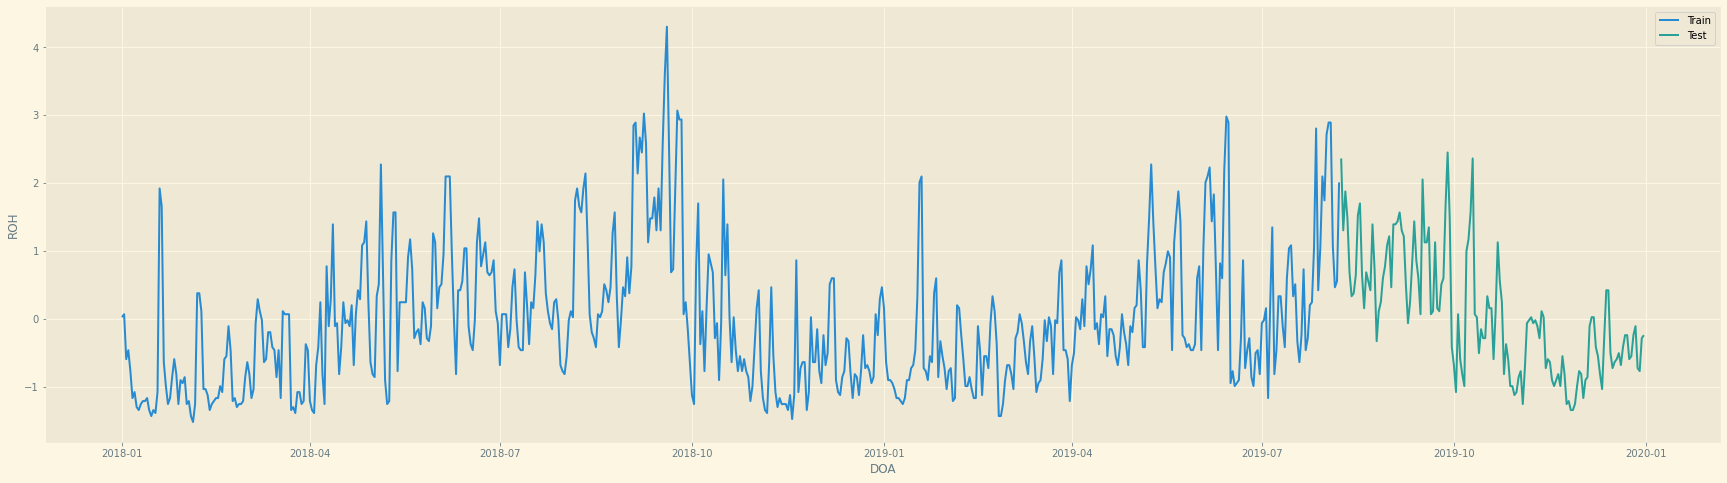

In [7]:
plt.plot(train.index, train['ROH'], label='Train')
plt.plot(test.index, test['ROH'], label='Test')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

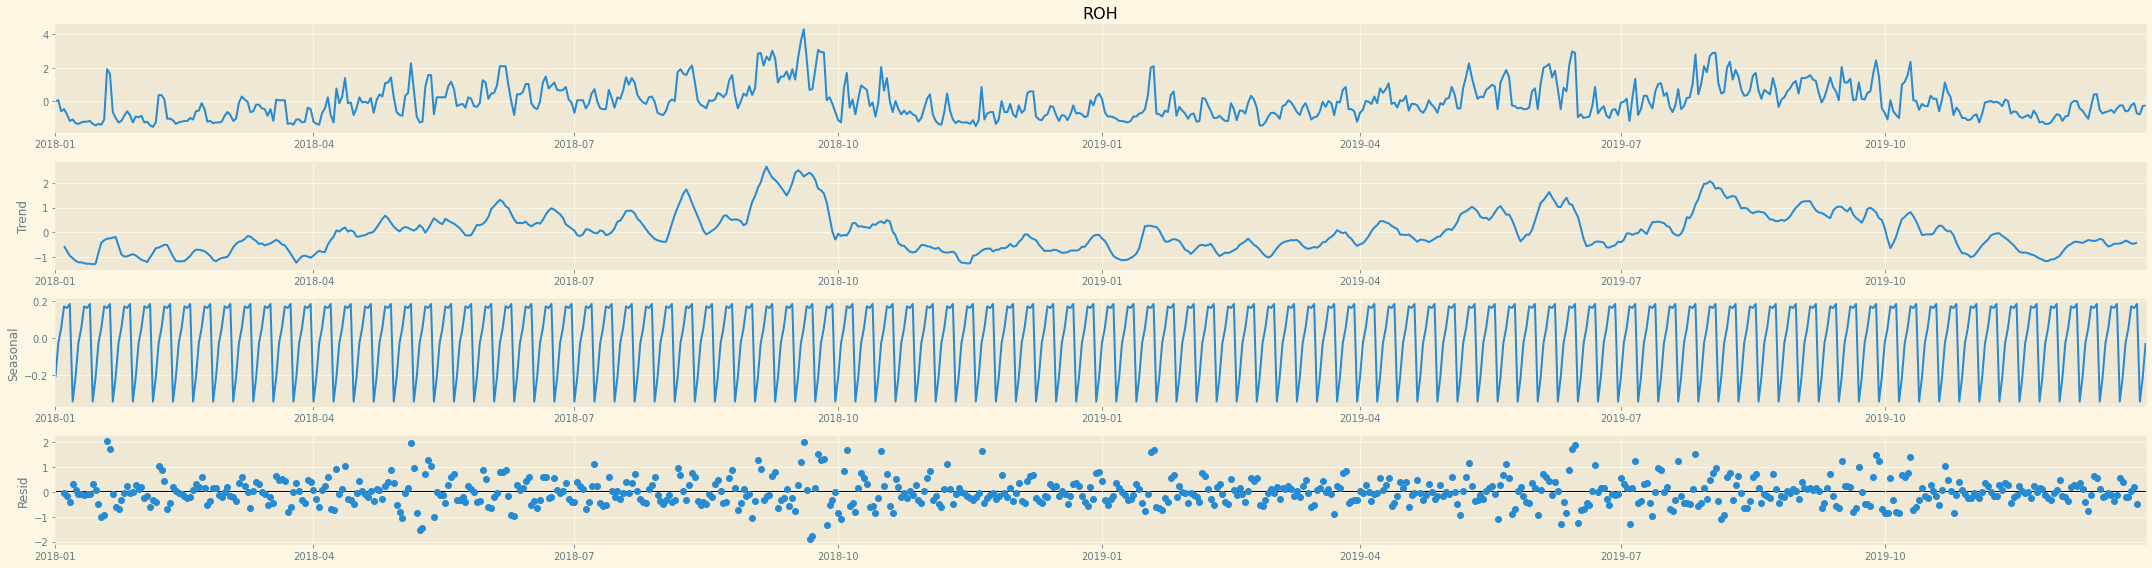

In [8]:
sm.tsa.seasonal_decompose(df.ROH).plot()
result = sm.tsa.stattools.adfuller(df.ROH)
plt.show()

In [9]:
from pmdarima.arima import ADFTest, auto_arima

In [10]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')
df = preprocess(df)
train, test = train_test_split(df)

In [11]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(train)
# From the above, we can conclude that the data is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

(0.01, False)

In [12]:
auto_arima(train, start_p = 0, d = 1, start_q = 0,
            max_p = 3, max_d = 3, max_q = 3, 
            start_P = 0, D = 1, start_Q = 0, m = 7, seasonal = True,
            error_action = 'warn', trace = True, supress_warnings = True,
            stepwise = True, random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1786.765, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1632.016, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.52 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1783.298, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1568.398, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.21 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=1571.764, Time=0.09 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=1557.749, Time=0.17 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=1617.974, Time=0.10 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=1.35 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=0.75 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=1548.146, Time=0.27 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=1613.227, Time=0.14 sec
 ARIMA(3,1,0)(2,1,1)[7]             : AIC=inf, Time=2.53 s

ARIMA(order=(3, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 7),
      with_intercept=False)

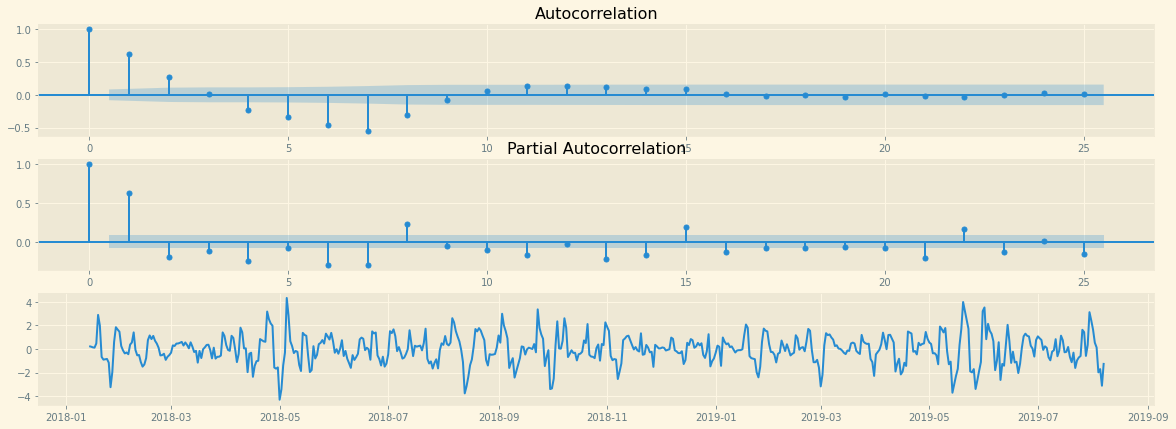

In [13]:
# Stationary data
train['station'] = train.ROH - train.ROH.rolling(7).mean()
train_st = train["station"]

fig, ax = plt.subplots(3, figsize=(20,7))
x = (train.station.dropna() - train.station.dropna().shift(7)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [14]:
sarima_model = SARIMAX(train_st, order=(3, 1, 1), seasonal_order=(2, 1, 1, 7), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [15]:
sarima_pred = sarima_fit.get_prediction("2019-08-08", "2019-12-31")
predicted_means = sarima_pred.predicted_mean + train['ROH'].rolling(7).mean().dropna().values[-146:]
predicted_intervals = sarima_pred.conf_int(alpha=0.05)
lower_bounds = predicted_intervals['lower station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]
upper_bounds = predicted_intervals['upper station'] + train['ROH'].rolling(7).mean().dropna().values[-146:]

Text(0.5, 1.0, 'SARIMA')

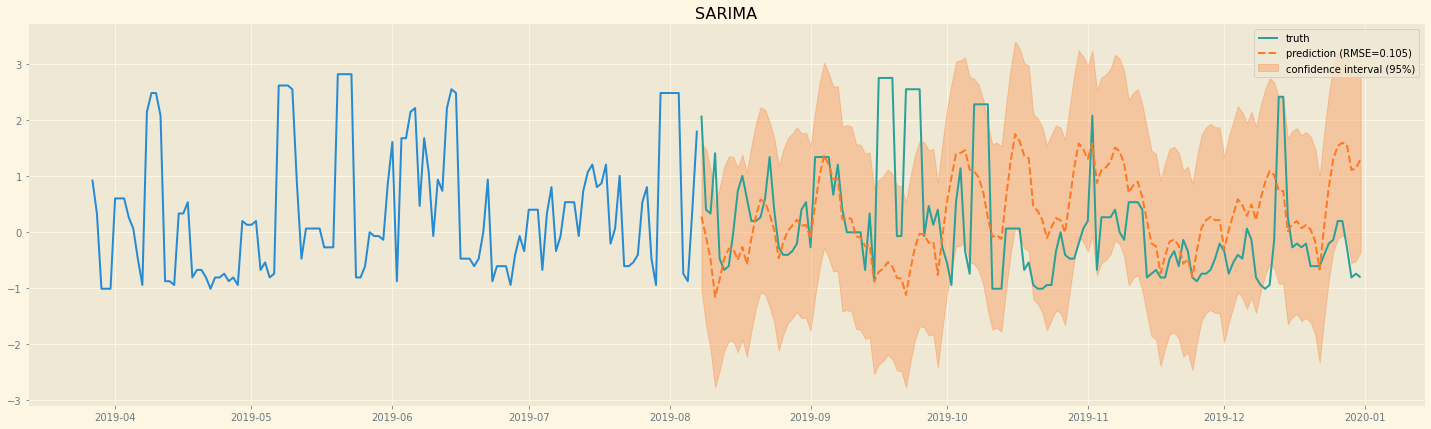

In [16]:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(df.ROH.index[450:-146], df.ROH.values[450:-146])
ax.plot(test['2019-08-08':].index, test['ROH'].values, label='truth')
ax.plot(test['2019-08-08':].index, predicted_means, color='#ff7823', linestyle='--', label="prediction (RMSE={:0.3f})".format(0.1052))
ax.fill_between(test['2019-08-08':].index, lower_bounds, upper_bounds, color='#ff7823', alpha=0.3, label="confidence interval (95%)")
ax.legend()
ax.set_title("SARIMA")

In [17]:
forecast_accuracy(predicted_means,test['ROH'])

1.2266	&	31.7305	&	0.9448	&	5117.6227	&	1.2407	&	1.5394	&	-0.5542


Check if time serise is stationary:
- You need differencing only if series is non-stationary. You can check that if the P Value > 0.05 we go ahead with finding the order of differencing. 
- Else, no differencing is needed, that is, d=0.

In [9]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train.ROH.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Test: ' ,result[1]>0.05)

ADF Statistic: -3.123065
p-value: 0.024893
Test:  False


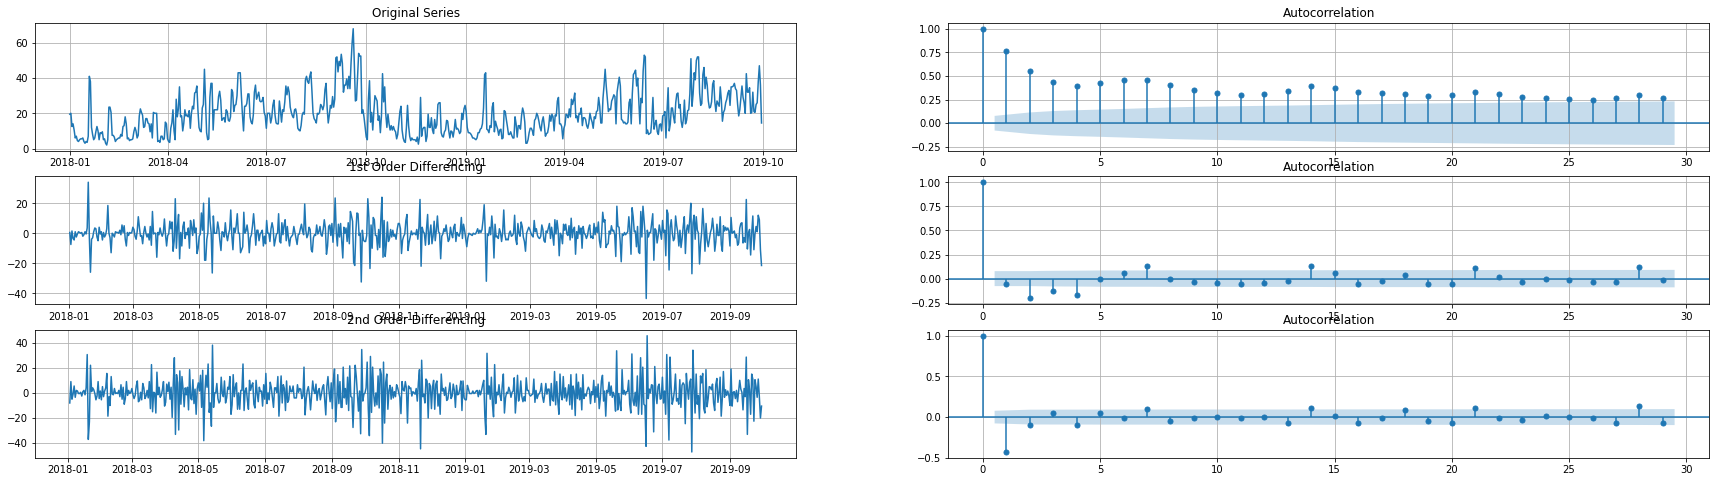

In [10]:
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(train.ROH) 
axes[0, 0].set_title('Original Series')
plot_acf(train.ROH, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train.ROH.diff()) 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train.ROH.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train.ROH.diff().diff()) 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train.ROH.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [11]:
# 1,1,2 ARIMA Model
model = ARIMA(train.ROH, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D.ROH   No. Observations:                  637
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2174.702
Method:                       css-mle   S.D. of innovations              7.347
Date:                Thu, 14 Jan 2021   AIC                           4359.404
Time:                        07:23:50   BIC                           4381.688
Sample:                    01-02-2018   HQIC                          4368.056
                         - 09-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0269      0.047      0.577      0.564      -0.064       0.118
ar.L1.D.ROH     0.4239      0.071      5.970      0.000       0.285       0.563
ma.L1.D.ROH    -0.6556      0.073     -8.981    

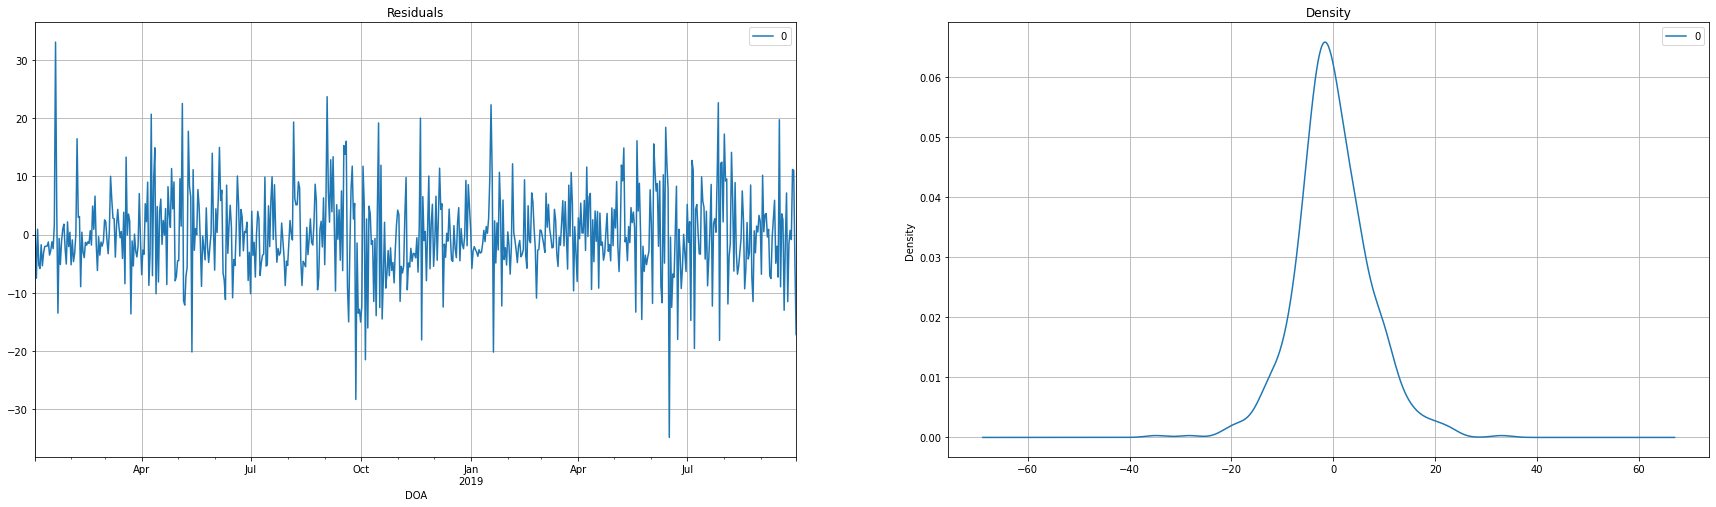

In [12]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

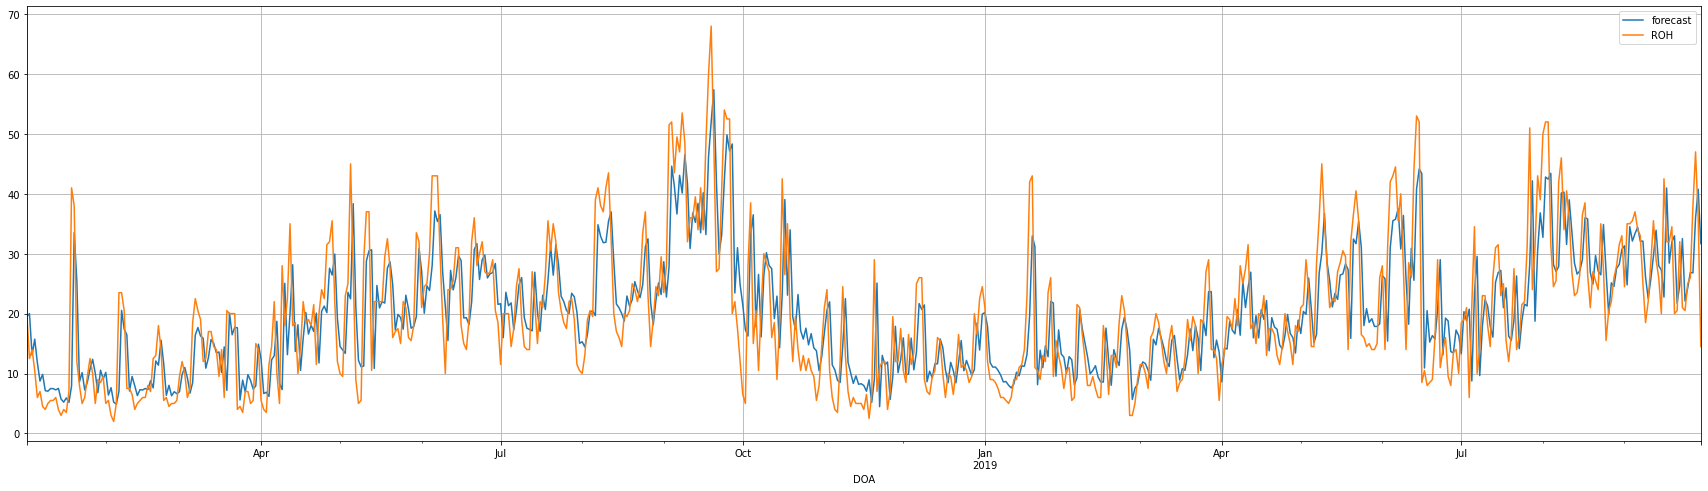

In [13]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [14]:
model = pm.auto_arima(train.ROH, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4462.435, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5815.577, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4461.211, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5193.338, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4462.759, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4459.863, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4366.322, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4441.760, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4382.947, Time=0.46 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4368.170, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4361.839, Time=0.55 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4394.421, Time=0.26 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4394.146, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=4362.787, Time=0.66 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept

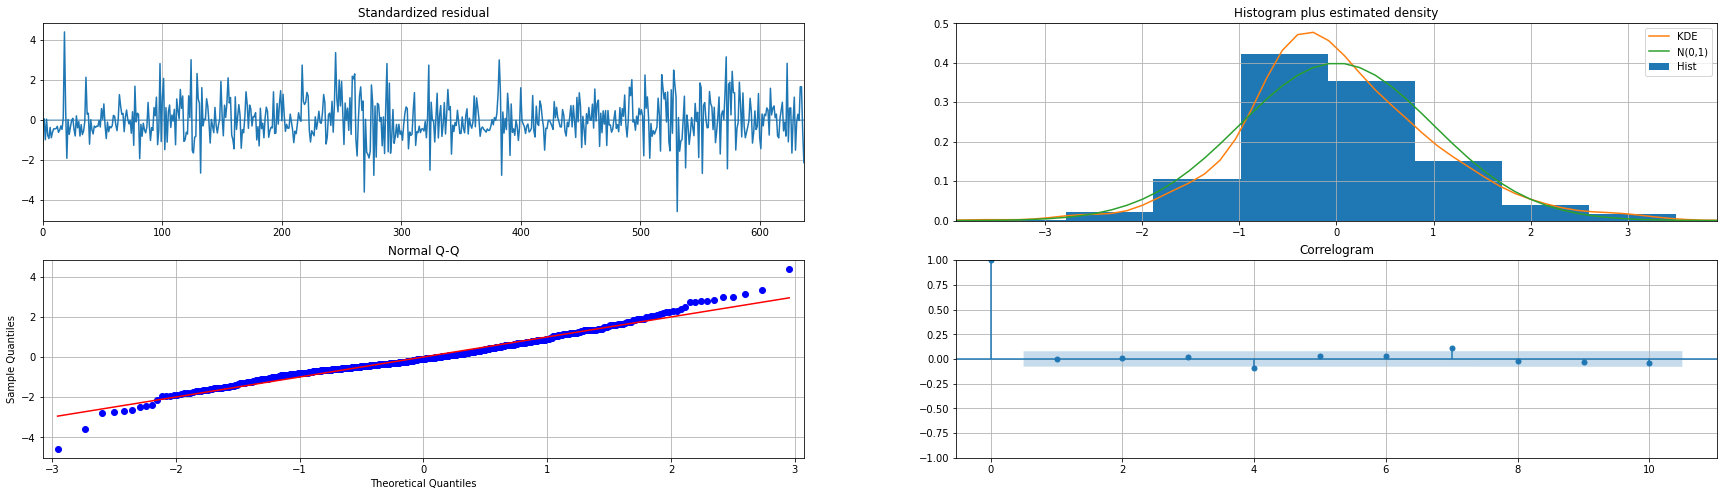

In [15]:
model.plot_diagnostics()
plt.show()

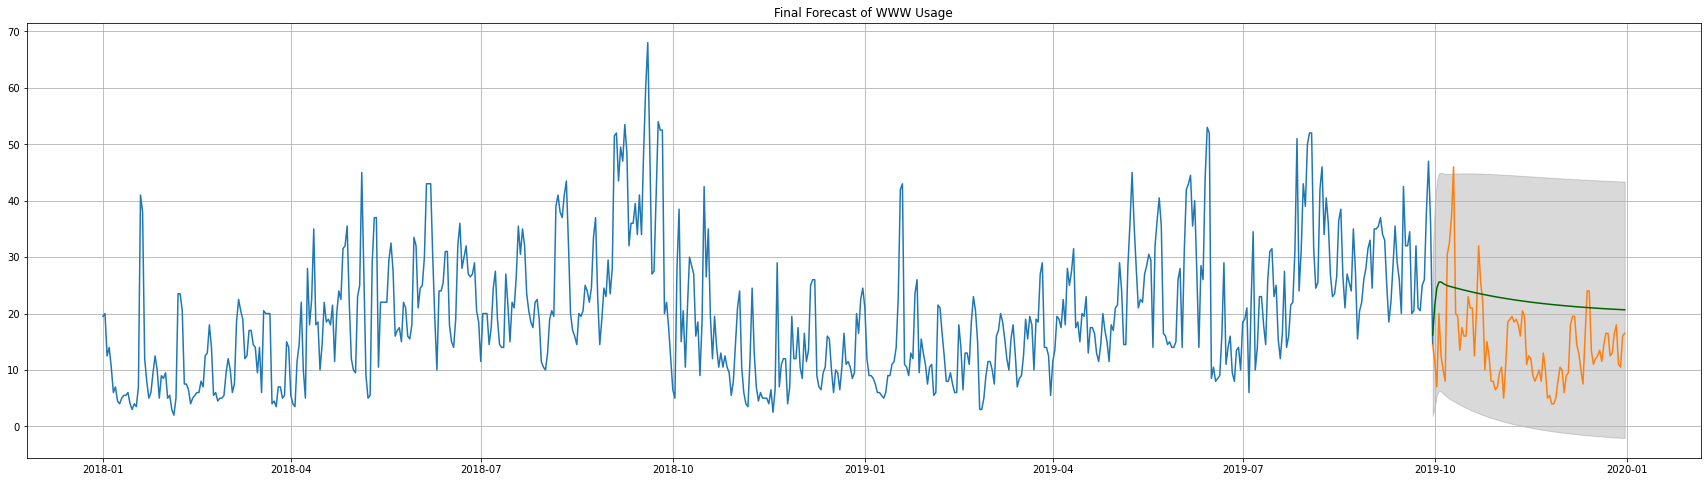

In [16]:
# Forecast
n_periods = 93
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = test.index #np.arange(len(train.ROH), len(train.ROH)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train.ROH)
plt.plot(test)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

In [17]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    # corr = np.corrcoef(forecast, actual)[0,1]   # corr
    # mins = np.amin(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # maxs = np.amax(np.hstack([forecast[:,None], 
    #                           actual[:,None]]), axis=1)
    # minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse}) #, 'acf1':acf1, 'corr':corr, 'minmax':minmax

In [18]:
forecast_accuracy(fc_series.values,test.values)

{'mape': 0.9670623323832062,
 'me': 7.660316248023262,
 'mae': 9.285043485860037,
 'mpe': 0.9202285658841552,
 'rmse': 10.633871283518555}

# SARIMA

In [19]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=4399.561, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4949.035, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=4402.101, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=4544.222, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5815.577, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=4397.918, Time=0.10 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=4399.523, Time=0.50 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=4399.468, Time=1.27 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=4565.143, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=4400.119, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=4394.421, Time=0.29 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=4396.123, Time=0.99 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=4396.149, Time=0.89 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=4396.525, Time=1.24 sec
 ARIMA(2,0,0)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  638
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -2174.919
Date:                Thu, 14 Jan 2021   AIC                           4361.839
Time:                        07:24:10   BIC                           4388.589
Sample:                             0   HQIC                          4372.223
                                - 638                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2144      0.151      1.424      0.154      -0.081       0.510
ar.L1          1.6501      0.049     33.571      0.000       1.554       1.746
ar.L2         -0.8511      0.065    -13.042      0.000      -0.979      -0.723
ar.L3          0.1901      0.038      4.955      0.000       0.115       0.265
ma.L1         -0.8833      0.037    -23.909      0.000      -0.956      -0.811
sigma2        53.4137      2.539     21.038      0.000      48.438      58.390
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                85.42
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.26
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

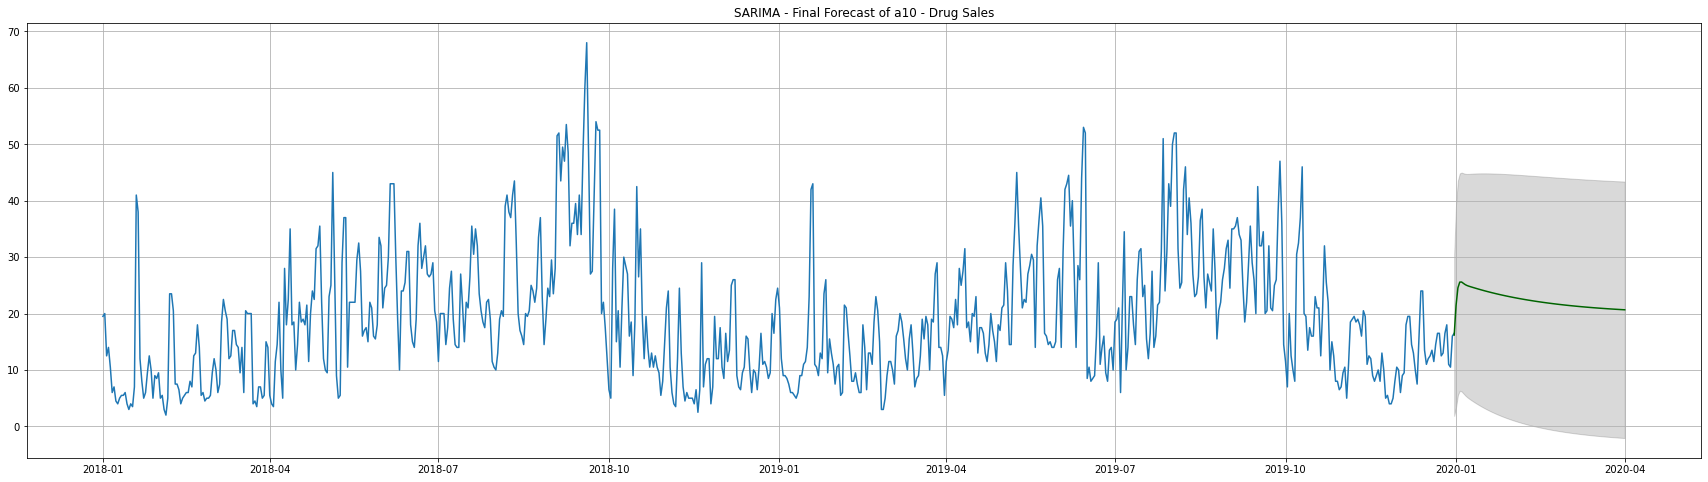

In [20]:
# Forecast
n_periods = 93
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='d')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()